# Training a model with a curated image dataset in fastai
Walkthrough of how to train a deep learning model in fastai with a curated image dataset


In [8]:
# imports for notebook boilerplate
!pip install -Uqq fastbook
import fastbook
from fastbook import *
from fastai.vision.all import *

In [9]:
# set up the notebook for fast.ai
fastbook.setup_book()

# Ingest the dataset
- create a path object
- defined an ImageDataLoaders object

In [10]:
# ingest the curated image dataset CIFAR
path = untar_data(URLs.CIFAR)

In [11]:
# examine the directory structure of the dataset
path.ls()

(#3) [Path('/storage/data/cifar10/train'),Path('/storage/data/cifar10/labels.txt'),Path('/storage/data/cifar10/test')]

In [12]:
'''pets1 = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files,
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'))
'''
db = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files,
                 splitter=RandomSplitter(seed=42),
                 get_y=parent_label)

In [13]:
dls = db.dataloaders(path,bs=32)

In [5]:
# dls = db.dataloaders(path,bs=32)
#dls = ImageDataLoaders.from_folder(path, train='train', valid='test')

In [16]:
# summary must be run on DataBlock object, not dataloaders object
db.summary(path/"train")



Setting-up type transforms pipelines
Found 50000 items
2 datasets of sizes 40000,10000
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /storage/data/cifar10/train/truck/3702_truck.png
    applying PILBase.create gives
      PILImage mode=RGB size=32x32
  Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /storage/data/cifar10/train/truck/3702_truck.png
    applying parent_label gives
      truck
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(9)

Final sample: (PILImage mode=RGB size=32x32, TensorCategory(9))


Setting up after_item: Pipeline: ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: IntToFloatTensor -- {'div': 255.0, 'div_mask': 1}

Building one batch
Applying item_tfms to the firs

# Examine the dataset

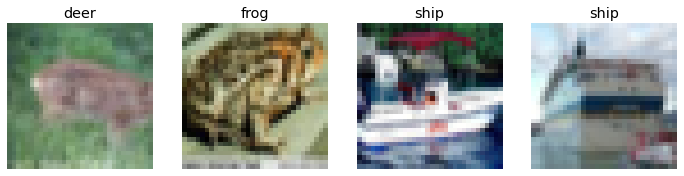

In [17]:
# show a batch of training data
dls.train.show_batch(max_n=4, nrows=1)


In [18]:
# examine the train subdirectory
(path/'train').ls()

(#10) [Path('/storage/data/cifar10/train/horse'),Path('/storage/data/cifar10/train/dog'),Path('/storage/data/cifar10/train/ship'),Path('/storage/data/cifar10/train/frog'),Path('/storage/data/cifar10/train/truck'),Path('/storage/data/cifar10/train/deer'),Path('/storage/data/cifar10/train/airplane'),Path('/storage/data/cifar10/train/automobile'),Path('/storage/data/cifar10/train/cat'),Path('/storage/data/cifar10/train/bird')]

In [19]:
(path/'train/dog').ls()

(#5000) [Path('/storage/data/cifar10/train/dog/26785_dog.png'),Path('/storage/data/cifar10/train/dog/47662_dog.png'),Path('/storage/data/cifar10/train/dog/48730_dog.png'),Path('/storage/data/cifar10/train/dog/40889_dog.png'),Path('/storage/data/cifar10/train/dog/24363_dog.png'),Path('/storage/data/cifar10/train/dog/44046_dog.png'),Path('/storage/data/cifar10/train/dog/26962_dog.png'),Path('/storage/data/cifar10/train/dog/19003_dog.png'),Path('/storage/data/cifar10/train/dog/47416_dog.png'),Path('/storage/data/cifar10/train/dog/31111_dog.png')...]

In [20]:
(path/'train/cat').ls()

(#5000) [Path('/storage/data/cifar10/train/cat/1845_cat.png'),Path('/storage/data/cifar10/train/cat/26087_cat.png'),Path('/storage/data/cifar10/train/cat/24817_cat.png'),Path('/storage/data/cifar10/train/cat/47541_cat.png'),Path('/storage/data/cifar10/train/cat/44852_cat.png'),Path('/storage/data/cifar10/train/cat/37669_cat.png'),Path('/storage/data/cifar10/train/cat/11236_cat.png'),Path('/storage/data/cifar10/train/cat/4329_cat.png'),Path('/storage/data/cifar10/train/cat/44859_cat.png'),Path('/storage/data/cifar10/train/cat/22425_cat.png')...]

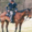

In [21]:
# take a look at one of the images
img_files = get_image_files(path)
img = PILImage.create(img_files[100])
img

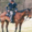

In [22]:
# display a thumbnail of the image
img.to_thumb(180)

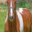

In [23]:
img = PILImage.create(img_files[3000])
img

# Define and train the model

In [24]:
#learn = cnn_learner(dls, resnet18, pretrained=False,
#                    loss_func=LabelSmoothingCrossEntropy(), metrics=accuracy)
learn = cnn_learner(dls, resnet18, 
                    loss_func=LabelSmoothingCrossEntropy(), 
                    metrics=accuracy)

In [25]:
%%time
learn.fine_tune(5)

epoch,train_loss,valid_loss,accuracy,time
0,1.819077,1.708099,0.458333,01:48


epoch,train_loss,valid_loss,accuracy,time
0,1.312125,1.193952,0.699333,02:10
1,1.136654,1.025145,0.769583,02:11
2,0.997877,0.975346,0.792083,02:10
3,0.860804,0.959976,0.798750,02:11
4,0.800234,0.962476,0.801917,02:12


CPU times: user 12min 20s, sys: 11 s, total: 12min 31s
Wall time: 12min 44s


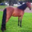

In [26]:
# take a look at one of the test images
img_test_files = get_image_files(path/"test")
img2 = PILImage.create(img_test_files[700])
img2

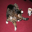

In [27]:
# select an image from the test set
img3 = PILImage.create(img_test_files[8000])
img3

In [28]:
# apply the trained model to the image
learn.predict(img2)

('horse',
 TensorImage(7),
 TensorImage([0.0137, 0.0173, 0.0137, 0.0105, 0.0029, 0.0047, 0.0283, 0.8784, 0.0145, 0.0160]))

In [29]:
# apply the trained model to the image
learn.predict(img3)

('dog',
 TensorImage(5),
 TensorImage([0.0264, 0.0138, 0.0052, 0.3400, 0.0075, 0.5631, 0.0186, 0.0133, 0.0055, 0.0065]))

In [30]:
learn.path = Path('/notebooks/temp')
learn.export('cifar_jun1_2021.pkl')

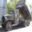

In [31]:
# select an image from the test set
img4 = PILImage.create(img_test_files[4000])
img4

In [32]:
learn.predict(img4)

('truck',
 TensorImage(9),
 TensorImage([0.0047, 0.0102, 0.0085, 0.0154, 0.0088, 0.0081, 0.0128, 0.0096, 0.0039, 0.9181]))

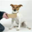

In [33]:
# take a look at a dog image from the training dataset
dog_files = get_image_files(path/"train/dog")
dog_img = PILImage.create(dog_files[30])
dog_img

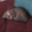

In [34]:
# take a look at a cat image from the training dataset
cat_files = get_image_files(path/"train/cat")
cat_img = PILImage.create(cat_files[30])
cat_img